# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

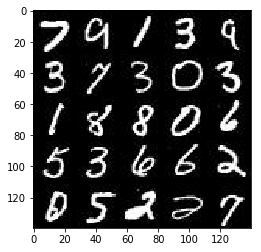

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

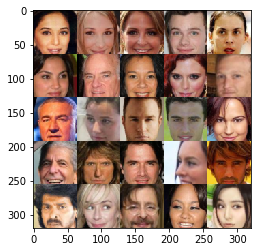

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
    
        # Define Vars
        strides = 2
        kernel = 5
        alpha = 0.2
        dropout = 0.2
        
        # Build Conv Net Considering that the input size is 28x28x3
        conv_1 = tf.layers.conv2d(images, 128, kernel, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L_ReLU_1 = tf.maximum(alpha * conv_1, conv_1)
        # 14x14x128
        
        conv_2 = tf.layers.conv2d(L_ReLU_1, 256, kernel, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_2 = tf.layers.dropout(conv_2, rate=dropout, training=True)
        b_norm_2 = tf.layers.batch_normalization(drop_2, training=True)
        L_ReLU_2 = tf.maximum(alpha * b_norm_2, b_norm_2)
        # 7x7x256
        
        conv_3 = tf.layers.conv2d(L_ReLU_2, 512, kernel, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_3 = tf.layers.dropout(conv_3, rate=dropout, training=True)
        b_norm_3 = tf.layers.batch_normalization(drop_3, training=True)
        L_ReLU_3 = tf.maximum(alpha * b_norm_3, b_norm_3)
        # 4x4x512
        
        # Flatten
        flat_layer = tf.reshape(L_ReLU_3, (-1, 4*4*512))
        logits = tf.layers.dense(flat_layer, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Define Vars
        strides = 2
        kernel = 5
        alpha = 0.2
        dropout = 0.2
        
        # Fully Connected Start
        dense_1 = tf.layers.dense(z, 7*7*512)
        reshape_1 = tf.reshape(dense_1, (-1, 7, 7, 512))
        b_norm_1 = tf.layers.batch_normalization(reshape_1, training=is_train)
        L_ReLU_1 = tf.maximum(alpha * b_norm_1, b_norm_1)
        # 7x7x512
        
        # Start Convolutions
        conv_1 = tf.layers.conv2d_transpose(reshape_1, 256, kernel, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_1 = tf.layers.dropout(conv_1, rate=dropout, training=True)
        b_norm_2 = tf.layers.batch_normalization(drop_1, training=is_train)
        L_ReLU_2 = tf.maximum(alpha * b_norm_2, b_norm_2)
        # 14x14x256
        
        conv_2 = tf.layers.conv2d_transpose(L_ReLU_2, 128, kernel, strides=strides, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_2 = tf.layers.dropout(conv_2, rate=dropout, training=True)
        b_norm_3 = tf.layers.batch_normalization(drop_2, training=is_train)
        L_ReLU_3 = tf.maximum(alpha * b_norm_3, b_norm_3)
        # 28*28*128
        
        logits = tf.layers.conv2d_transpose(L_ReLU_3, out_channel_dim, kernel, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        # 28x28x5
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator Output
    g_out = generator(input_z, out_channel_dim)
    
    # Discriminator Outputs and Logits for Real and Fake Data
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)
    
    # Generator Loss
    g_scewl = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_out) * 0.9)
    g_loss = tf.reduce_mean(g_scewl)
    
    # Discriminator Loss
    d_real_scewl = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_out))
    d_real_loss = tf.reduce_mean(d_real_scewl)
    
    d_fake_scewl = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_out))
    d_fake_loss = tf.reduce_mean(d_fake_scewl)
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_trainer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_trainer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_trainer, g_trainer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 19.1424
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 18.1415
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 16.6048
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 15.9617
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 15.3936
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 14.7856
Epoch 1/2... Discriminator Loss: 2.9252... Generator Loss: 4.5209
Epoch 1/2... Discriminator Loss: 3.9253... Generator Loss: 5.8588
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 3.6404
Epoch 1/2... Discriminator Loss: 0.2554... Generator Loss: 2.7117


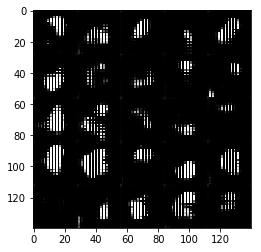

Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 7.1444
Epoch 1/2... Discriminator Loss: 0.0682... Generator Loss: 3.0068
Epoch 1/2... Discriminator Loss: 2.9966... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 0.5675... Generator Loss: 1.4279
Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 0.5683
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.2680
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 3.5397
Epoch 1/2... Discriminator Loss: 2.1278... Generator Loss: 0.4029
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 2.5964


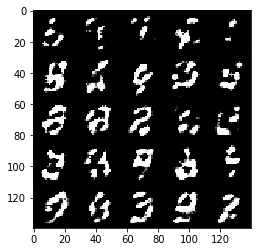

Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 0.2451... Generator Loss: 2.6386
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 2.4751
Epoch 1/2... Discriminator Loss: 0.2305... Generator Loss: 2.1328
Epoch 1/2... Discriminator Loss: 0.2563... Generator Loss: 1.8731
Epoch 1/2... Discriminator Loss: 0.1205... Generator Loss: 3.0396
Epoch 1/2... Discriminator Loss: 1.7334... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 4.1948
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8012


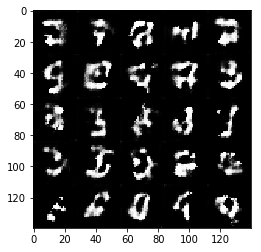

Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 1.5171
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.8153


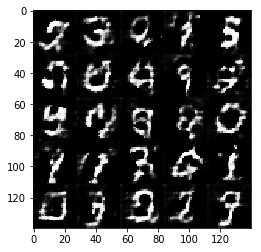

Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 2.1310
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 2.4739... Generator Loss: 3.5743
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 2.3606
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.0059


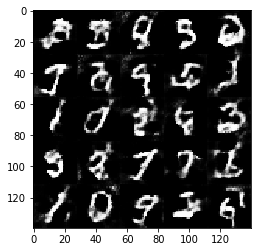

Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.6503... Generator Loss: 1.9054
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.3685
Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.9387... Generator Loss: 3.4602


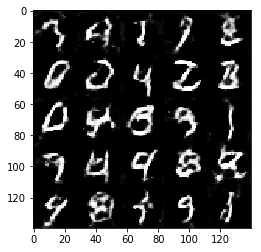

Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 1.6670
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.9757
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.8075
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.7139


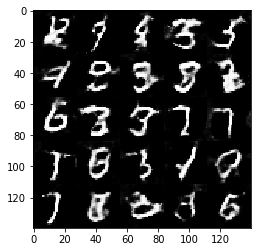

Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.7117
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 1.9586


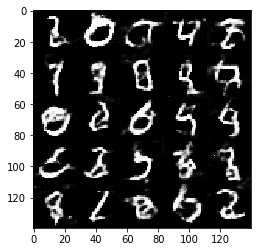

Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 2.7648
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 2.0263
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.1949
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 2.7363
Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 2.8308
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.3101


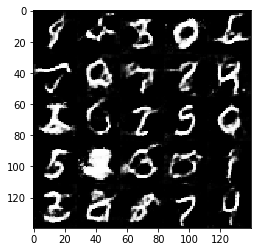

Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 2.4547
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 1.4382
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 2.6542
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.6705... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.5213
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.5564


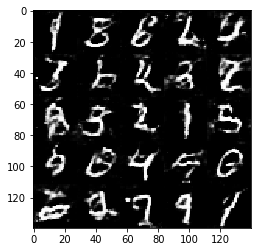

Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 3.7984
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.0563
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.2884
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 2.4922


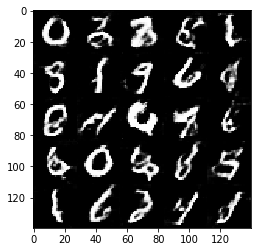

Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 2.1828
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.8932
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.8749
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 3.2676
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 0.9947


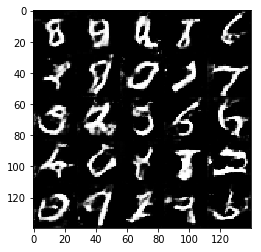

Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.9546
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 1.8401
Epoch 2/2... Discriminator Loss: 0.4552... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 1.7291... Generator Loss: 0.4802
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.2305
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 0.4780... Generator Loss: 1.3838


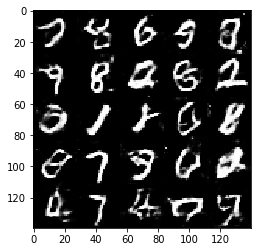

Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.6421
Epoch 2/2... Discriminator Loss: 0.3766... Generator Loss: 1.7371
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.3145
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 2.3151
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.6982
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.9094


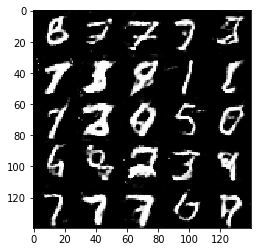

Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 0.4635... Generator Loss: 1.7264
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.8864
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.1383
Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.4910
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 1.3747
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.4014


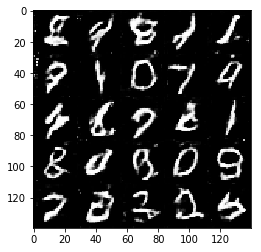

Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 2.6857
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.1580


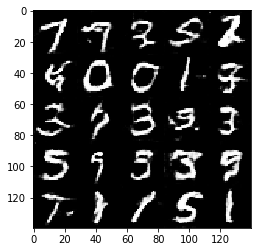

Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 2.2546
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.4784... Generator Loss: 2.1698
Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 2.1305
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 3.3799
Epoch 2/2... Discriminator Loss: 1.4452... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 0.4043... Generator Loss: 1.6904


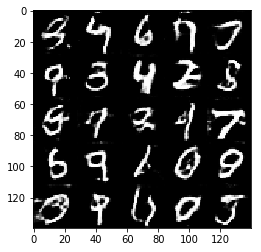

Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 0.3212... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 1.5286
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 2.4804
Epoch 2/2... Discriminator Loss: 0.2689... Generator Loss: 2.3300
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 2.4848


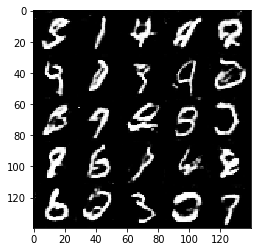

Epoch 2/2... Discriminator Loss: 0.3064... Generator Loss: 1.9586
Epoch 2/2... Discriminator Loss: 1.7300... Generator Loss: 0.5190
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 2.2314
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.4409


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1196... Generator Loss: 3.2282
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 3.5035
Epoch 1/1... Discriminator Loss: 0.2860... Generator Loss: 2.2138
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 2.4970
Epoch 1/1... Discriminator Loss: 0.2454... Generator Loss: 1.7200
Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 3.2630
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 3.9218
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 3.4078
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 5.1118


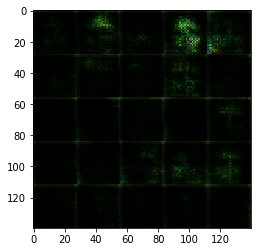

Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 4.5576
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 5.1692
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 5.2243
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 4.4725
Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 4.8300
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 4.7182
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 4.7792
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 4.3382
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 4.9090
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.2115


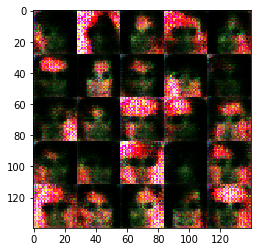

Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 2.6369
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 2.8281
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 0.0853... Generator Loss: 2.9091
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 3.2564
Epoch 1/1... Discriminator Loss: 3.7997... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 4.6733


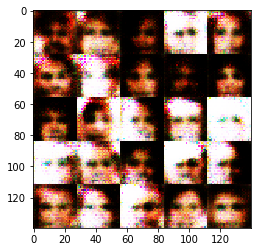

Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 2.7803
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 4.6591
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 3.9595
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 4.8883
Epoch 1/1... Discriminator Loss: 2.2361... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.1128... Generator Loss: 3.4020
Epoch 1/1... Discriminator Loss: 0.1702... Generator Loss: 3.3614
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 2.2892


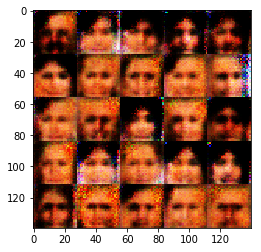

Epoch 1/1... Discriminator Loss: 4.7840... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 2.4731
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 1.7236
Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 2.5248
Epoch 1/1... Discriminator Loss: 0.2396... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 0.2376... Generator Loss: 3.7856
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 2.7159
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 4.4444


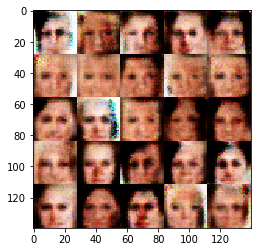

Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 5.2120
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 3.1920
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 3.9509
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 3.4865
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 1.9568
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 4.8966
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 4.0315


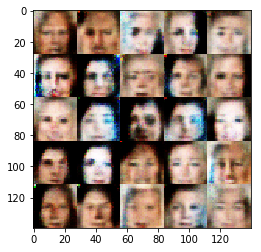

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 6.2900
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 3.0635
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 3.7076
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.2232
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 2.0228
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 2.9970
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 7.1763
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 2.2851


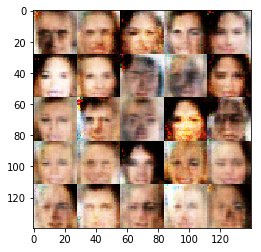

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 3.7260... Generator Loss: 7.2276
Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 2.1856
Epoch 1/1... Discriminator Loss: 0.2065... Generator Loss: 2.4639
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 0.2421... Generator Loss: 3.7616
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 3.5109


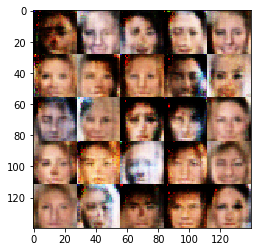

Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 1.6935
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 3.6651
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 3.2019
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 1.6954
Epoch 1/1... Discriminator Loss: 1.6864... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 1.9640
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 3.3051


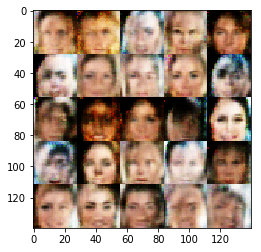

Epoch 1/1... Discriminator Loss: 0.0954... Generator Loss: 3.9937
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.8268
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 3.5306... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.1128
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 2.1638
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 2.6672
Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 2.6511


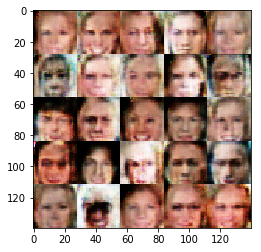

Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 1.8541
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 5.9807
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 2.5289
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 3.1265
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 3.5876
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.2141


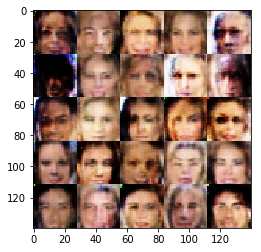

Epoch 1/1... Discriminator Loss: 0.2405... Generator Loss: 3.8441
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 2.9523
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 1.9314
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 4.8012
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 2.2153
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 3.0277
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.7662
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 1.5384


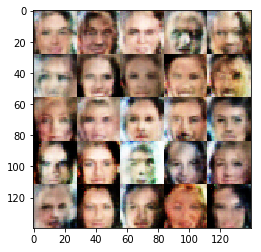

Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 3.2940
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 3.0382
Epoch 1/1... Discriminator Loss: 0.3251... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.1818... Generator Loss: 2.4902
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.1524... Generator Loss: 3.0214
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 3.3643


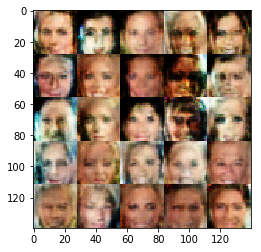

Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 5.2440
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 2.3214
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 2.2009
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 4.8295
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.0113
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 2.3987


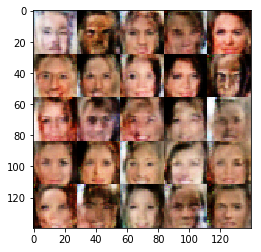

Epoch 1/1... Discriminator Loss: 0.2713... Generator Loss: 2.1089
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 2.7831
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 2.1322
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 4.4737
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.0649
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.4042
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 2.8053


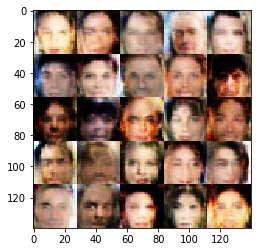

Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 2.5829
Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 2.4190
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 3.5334
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 3.8973
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 0.9342


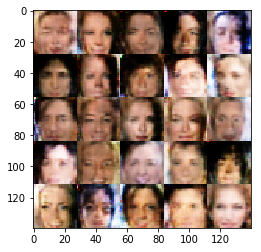

Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 2.8686
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.9597
Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 2.0949
Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 2.3014
Epoch 1/1... Discriminator Loss: 0.2283... Generator Loss: 2.5145
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 2.1648


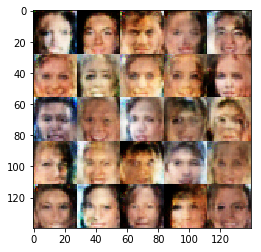

Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 2.7679
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 2.6004
Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 2.5747
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 1.7567
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 3.3708
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 2.1542
Epoch 1/1... Discriminator Loss: 3.2805... Generator Loss: 5.5158


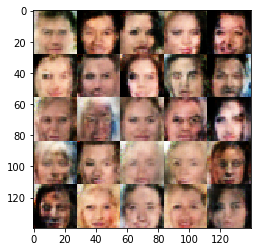

Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.6780... Generator Loss: 3.8150
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.1261... Generator Loss: 2.5139


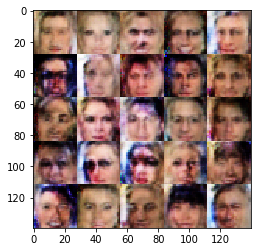

Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 4.0452
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 2.3961... Generator Loss: 5.4468
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 1.7085
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 3.3217
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 1.8998... Generator Loss: 2.5422


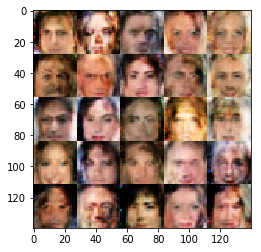

Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 2.6639
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.2824
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.6406


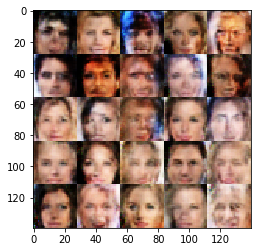

Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 4.3832
Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.8827


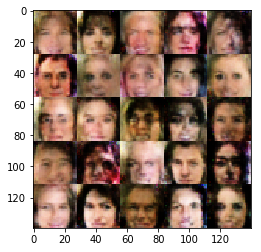

Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.5994
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 1.9887
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 3.2429
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 2.2487
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 3.7274
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.7322


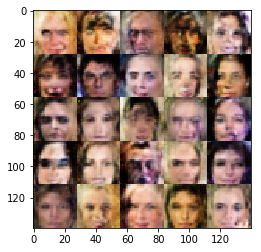

Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 2.0159
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 3.2203
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 2.0973
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 1.7499... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.7649


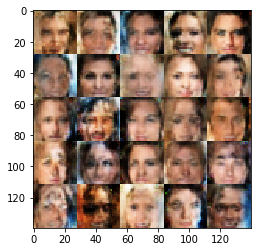

Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 2.0198
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 3.3335... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 2.0687
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 4.1657


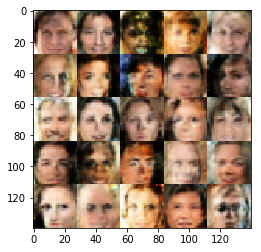

Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.0708
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 2.8930
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.5299


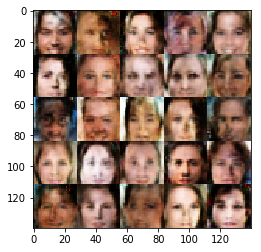

Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.4901
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 3.3591
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.8433... Generator Loss: 2.4309
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.9880


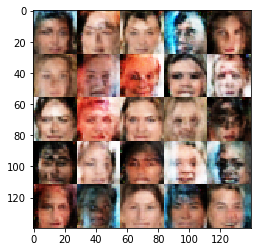

Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.9048
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 2.0225


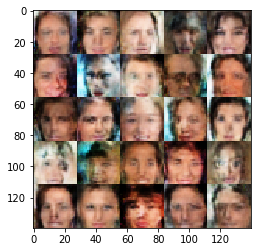

Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 1.7477
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 0.9744


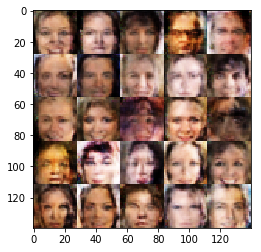

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 2.1103
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.7479... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.8230


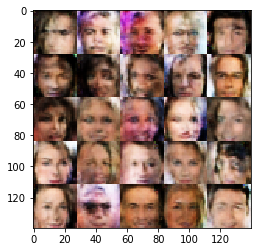

Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 2.4140
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 2.5435
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.1040


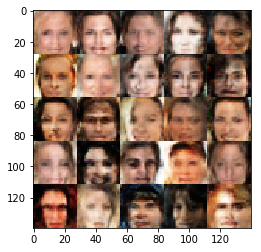

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.6414
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 2.2987
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.5768


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.